#구글드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


#Vanilla CNN Template


##모듈임포팅

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization, Conv2D, MaxPooling2D, Input
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l1, l2, L1L2
import time


from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2
import tensorflow as tf





In [3]:

model = keras.Sequential()
model.add(Input((224,224,3)))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(128, (3,3), padding='same'))
model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(256, (3,3), padding='same'))
model.add(Conv2D(256, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(512, (3,3), padding='same'))
model.add(Conv2D(512, (3,3), padding='same'))
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(512, (3,3), padding='same'))
model.add(Conv2D(512, (3,3), padding='same'))
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(64, activation='relu',kernel_regularizer=l2()))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

In [4]:
#실시간loss그래프
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()


  def on_epoch_end(self, epoch, logs={}):

    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])

In [5]:
plot_losses = PlotLosses()

##모델학습

In [6]:
#다중분류

from tensorflow .keras. optimizers import Adam
optimizer = Adam(learning_rate= 0.001*0.1, decay = 0.01 ) #lr
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model.summary()

def normalize(image):
  return image/255.0

preprocessor = normalize
BATCH_SIZE = 128

train_data_generator = ImageDataGenerator(
      # rotation_range=10,
      rotation_range=4, #bad1~3,good 4개
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=preprocessor
).flow_from_directory(
      "/content/gdrive/MyDrive/DATA0829/STAND1500/TRAIN",#학습시킬 경로
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "/content/gdrive/MyDrive/DATA0829/STAND1500/TEST", #test경로
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     1

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_check_point = ModelCheckpoint(
    'pose_best_model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True)
#모델체크포인트

'''
tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch', options=None, **kwargs
)
'''



"\ntf.keras.callbacks.ModelCheckpoint(\n    filepath, monitor='val_loss', verbose=0, save_best_only=False,\n    save_weights_only=False, mode='auto', save_freq='epoch', options=None, **kwargs\n)\n"

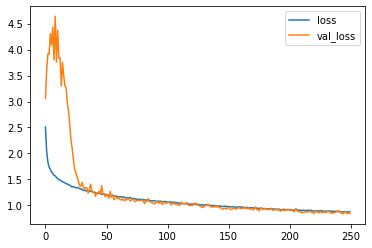

loss =  0.8766344785690308 , val_loss =  0.8414925932884216
20/20 [==============================] - 50s 2s/step - loss: 0.8766 - acc: 0.8712 - val_loss: 0.8415 - val_acc: 0.9220


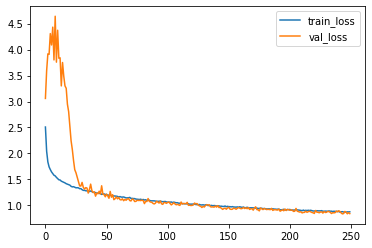

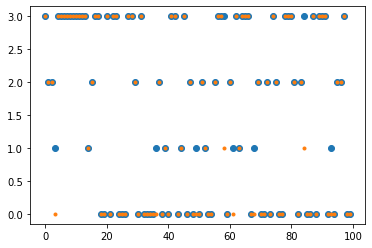

In [8]:
history = model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      steps_per_epoch=train_data_generator.samples/BATCH_SIZE,
      validation_steps=test_data_generator.samples/BATCH_SIZE,      
      epochs=250, callbacks=[model_check_point,plot_losses]
)

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

test_x, test_y = next(iter(test_data_generator))
y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(test_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


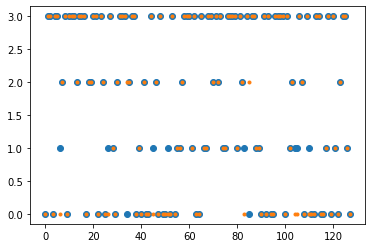

In [11]:
#test전체 확인
test_x, test_y = next(iter(test_data_generator))
y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(test_y, "o")
plt.plot(predicted, '.')
plt.show()


In [47]:
mv pose_best_model.h5 /content/gdrive/MyDrive/DATA0829/tmp_data/

In [9]:
cd /content/gdrive/MyDrive/DATA0829/tmp_data/ #모델저장경로

/content/gdrive/.shortcut-targets-by-id/1MDG2s4-vKr5cgqxI92I-2EcviNBlNQRc/DATA0829/tmp_data


In [10]:
from keras.models import load_model
model.save('pose_stand_model2.h5')